In [27]:
import anndata
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from kb_python.utils import import_matrix_as_anndata
import anndata 
from scipy.io import mmread
from mpl_toolkits.axes_grid1 import make_axes_locatable

fsize = 15
import sys

def nd(arr):
    return np.asarray(arr).reshape(-1)


def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, c="k", alpha=0.75, zorder=0)
    ax.set(**{"aspect": "equal", "xlim": lims, "ylim": lims})
    return ax


plt.rcParams.update({"font.size": fsize})
%config InlineBackend.figure_format = 'retina'

In [3]:
mtx = mmread("/home/cellatlas/human/data/colon/GSM3587010/mito_filter/matrix.mtx").tocsr()

In [16]:
from sklearn.linear_model import LinearRegression

In [17]:
alpha=0.1
def plot_meanvar(mtx, raw_mean, minlim=1e-4, maxlim=1e5, ax=None):
    p = {
        "xlabel": "Gene mean",
        "ylabel": "Gene variance",
        "xscale": "log",
        "yscale": "log",
        "xlim": (minlim, maxlim),
    }

    gvar = np.var(mtx, axis=0)
    gcov = np.sqrt(np.var(gvar)) / np.mean(gvar)

    y = np.var(mtx, axis=0)
    yy = (y - y.mean()) / np.sqrt(np.var(y))

    ax.scatter(
        raw_mean,
        y,
        facecolor="#7394B3",
        alpha=alpha,
        edgecolor="k",
        label=f"CoV: {gcov:,.1f}",
    )
    ax.legend(prop={"size": 12})
    ax.set(**p)
    yex(ax)
    return ax


def plot_depth(mtx, raw_cell_counts, ax):
    x = raw_cell_counts
    y = np.sum(mtx, axis=1)

    minx, maxx = min(x), max(x)
    miny, maxy = min(y), max(y)
    maxy = maxy - miny

    xx = (x - minx) / maxx
    yy = (y - miny) / maxy

    close = np.all(np.allclose(y, y[0]))
    if close:
        yy = [1] * len(y)
    
    ax.scatter(xx, yy, edgecolor="k", facecolor="#941655", alpha=alpha)

    reg = LinearRegression().fit(xx.reshape(-1, 1), yy)
    r2 = reg.score(xx.reshape(-1, 1), yy)

    if close:
        # handle the degenerate case where the slope is 0 since all values y are same
        r2 = 0

    xxx = np.array([min(xx), max(xx)])

    ax.plot(
        xxx,
        reg.coef_ * xxx + reg.intercept_,
        color="darkgray",
        linestyle="--",
        label=f"r$^2$: {r2:,.2f}",
        linewidth=3,
    )

    p = {
        "xlabel": "Raw cell count",
        "ylabel": "Transform cell count",
        "xlim": (-0.1, 1.1),
        "ylim": (-0.1, 1.1),
    }
    ax.set(**p)
    ax.legend(prop={"size": 12})
    return ax

In [7]:
raw = mtx.A
minlim = min(np.min(np.var(raw, 0)), np.min(np.mean(raw, 0))) * 0.1
maxlim = max(np.max(np.var(raw, 0)), np.max(np.mean(raw, 0))) * 10

In [8]:
minlim

0.0

In [24]:
from mx.mx_normalize import mx_normalize

In [25]:
norm = mx_normalize(mtx)

/home/sina/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


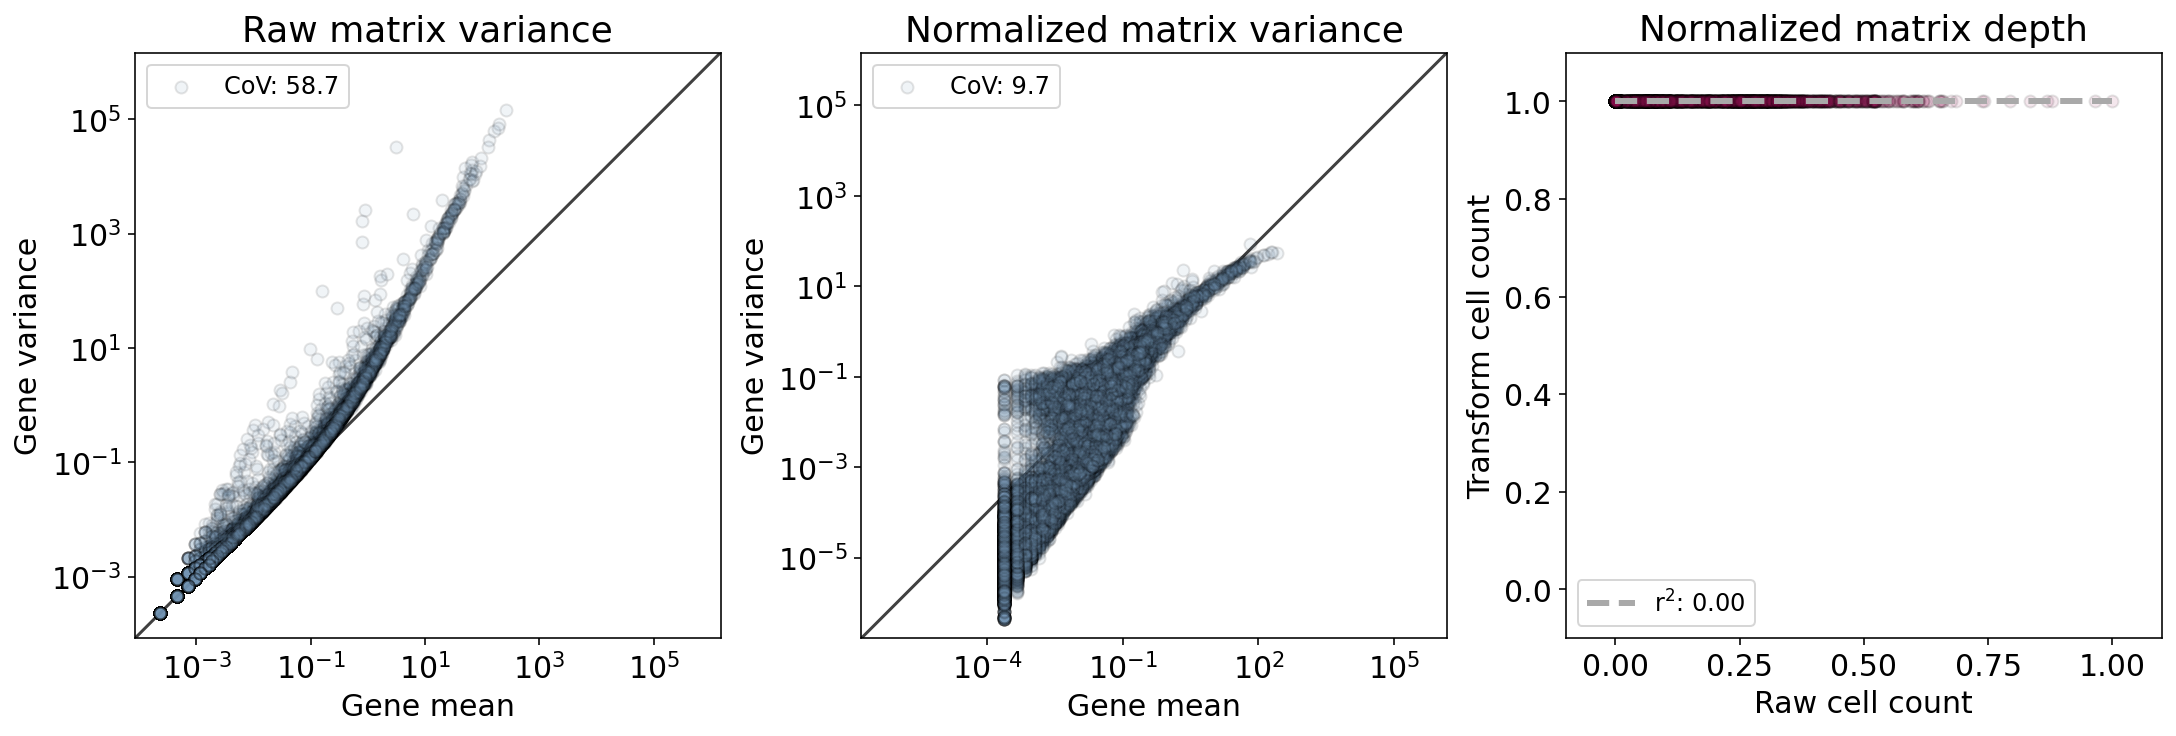

In [32]:
fig, axs = plt.subplots(figsize=(15,5), ncols=3, constrained_layout=True)

ax = axs[0]
plot_meanvar(mtx.A, raw.mean(0), minlim=minlim, maxlim=maxlim, ax=ax)
ax.set_title("Raw matrix variance")

# ax = axs[0,1]
# plot_depth(mtx.A, raw.sum(1), ax=ax)
# ax.set_title("Raw matrix depth")

ax = axs[1]
plot_meanvar(norm.A, raw.mean(0), minlim=minlim, maxlim=maxlim, ax=ax)
ax.set_title("Normalized matrix variance")

ax = axs[2]
plot_depth(norm.A, raw.sum(1), ax=ax)
ax.set_title("Normalized matrix depth")
fig.savefig("figures/mx_norm.png", dpi=300, bbox_inches="tight")
fig.show()